# to download the data from MSWEP, after getting google driver shared with email account http://www.gloh2o.org/mswep/

conda install -c conda-forge rclone

rclone size --drive-shared-with-me arge_mswx:MSWEP_V280/Past/Monthly/197902.nc


1. make sure the version of rclone is ablove 1.61
2. then well documented rconfig method, after entering n for all questions and choosing the correct service, then copy pasting the serverless option would work for google drive



# to subset data and create dataframe from 1979-2020

In [21]:
import pandas as pd
from datetime import datetime
import numpy as np
import rioxarray
import xarray as xr

min_lon = 31
min_lat = 0.0
max_lon = 37
max_lat = 6


datereg=pd.date_range(start='19790201',end='20201130', freq='1M')
datereg1=[x.strftime('%Y%m') for x in datereg]


datasets = []
for datr in datereg1:
    db=xr.open_dataset(f'/home/MSWEP/{datr}.nc')
    #subset = db.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    cropped_ds = db.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
    #print(datr)
    datasets.append(cropped_ds)

combined = xr.concat(datasets, dim='time')

In [6]:
combined['time']

<xarray.DataArray 'time' (time: 502)>
array(['1979-02-01T00:00:00.000000000', '1979-03-01T00:00:00.000000000',
       '1979-04-01T00:00:00.000000000', ..., '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
Attributes:
    long_name:  time

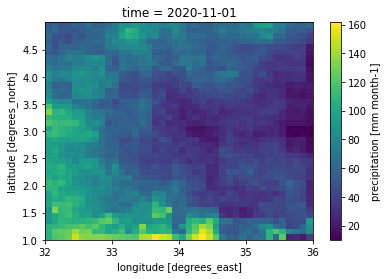

In [8]:
cropped_ds['precipitation'].plot()

# Based on this note using climate_indices lib
https://gist.github.com/monocongo/978348233b4bde80e9bcc52fe8e4150c

The gamma distibution selection following, https://edo.jrc.ec.europa.eu/documents/factsheets/factsheet_spi_ado.pdf

In [58]:
# standard library
import os
from tempfile import TemporaryDirectory
from typing import Dict

# third-party
from climate_indices.indices import spi, Distribution
from climate_indices.compute import Periodicity
import numpy as np
import pandas as pd
import requests
import xarray as xr

# create a wrapper function that can be applied to an entire Dataset
# (takes a DataArray as first argument, returns a DataArray)
def spi_wrapper(
    obj: xr.DataArray,
    precip_var: str,
    scale: int,
    distribution: Distribution,
    data_start_year: int,
    calibration_year_initial: int,
    calibration_year_final: int,
    periodicity: Periodicity,
    fitting_params: Dict = None,
) -> xr.DataArray:
    
    # compute SPI for this timeseries
    spi_data = spi(
        values=obj[precip_var].to_numpy(), #TODO find why we need to use the variable name rather than already using the variables's DataArray (i.e. why is obj a Dataset?)
        scale=scale,
        distribution=distribution,
        data_start_year=data_start_year,
        calibration_year_initial=calibration_year_initial,
        calibration_year_final=calibration_year_final,
        periodicity=periodicity,
        fitting_params=fitting_params,
    )

    #TODO for some reason this is necessary for the nClimGrid low-resolution example NetCDFs
    #TODO find out why
    #spi_data = spi_data.flatten()
    
    #TODO for some reason this is necessary for the NCO-modified nClimGrid normal-resolution example NetCDFs
    #TODO find out why
    spi_data = spi_data.reshape(spi_data.size, 1)
    
    # create the return DataArray (copy of input object's geospatial dims/coords plus SPI data)
    da_spi = xr.DataArray(
        dims   = obj[precip_var].dims,
        coords = obj[precip_var].coords,
        attrs  = {
            'description': 'SPI computed by the climate_indices Python package',
            'references': 'https://github.com/monocongo/climate_indices',
            'valid_min': -3.09, # this should mirror climate_indices.indices._FITTED_INDEX_VALID_MIN
            'valid_max':  3.09, # this should mirror climate_indices.indices._FITTED_INDEX_VALID_MAX
        },
        data = spi_data,
    )

    return da_spi


In [42]:
sc = combined.stack(grid_cells=('lat', 'lon',))

In [27]:
stacked_ds['precipitation'].dims

('time', 'grid_cells')

In [11]:
stacked_ds.groupby('grid_cells')

DatasetGroupBy, grouped over 'grid_cells'
3600 groups with labels (5.949999809265137,, 31.0499....

In [59]:
spi_ds = sc.groupby('grid_cells').apply(
    spi_wrapper,
    precip_var='precipitation',
    scale=3,
    distribution=Distribution.gamma,
    data_start_year=1979,
    calibration_year_initial=1995,
    calibration_year_final=2008,
    periodicity=Periodicity.monthly,
).unstack('grid_cells')

In [67]:
spi_ds[501]

<xarray.DataArray (lat: 60, lon: 60)>
array([[-0.12874253, -0.92288222, -1.3189307 , ...,  0.69977918,
         0.72617275,  0.50111454],
       [-0.08841552, -0.00353489, -1.09201472, ...,  0.7184468 ,
         0.70739244,  0.4118688 ],
       [ 0.07646091,  0.41106268,  0.08616979, ...,  0.65877655,
         0.62512207,  0.5191653 ],
       ...,
       [ 0.06635102, -0.20934402, -0.49072099, ...,  0.98420204,
         1.12547627,  1.02358172],
       [-0.52642658, -0.28886467, -0.50112548, ...,  1.01288522,
         1.00644458,  0.97966023],
       [-0.48111449, -0.52407465, -0.36872976, ...,  0.92619201,
         0.58989382,  0.53234392]])
Coordinates:
    time     datetime64[ns] 2020-11-01
  * lat      (lat) float64 0.05 0.15 0.25 0.35 0.45 ... 5.55 5.65 5.75 5.85 5.95
  * lon      (lon) float64 31.05 31.15 31.25 31.35 ... 36.65 36.75 36.85 36.95
Attributes:
    description:  SPI computed by the climate_indices Python package
    references:   https://github.com/monocongo/climate_indices
    valid_min:    -3.09
    valid_max:    3.09

In [12]:
def download(
    source_uri: str,
    destination_filepath: str,
) -> None:

    #TODO add URI validation check
    
    # make HTTP request for remote file data
    data = requests.get(source_uri)

    # save file data to local copy
    with open(destination_filepath, 'wb') as destination_file:
        destination_file.write(data.content)



In [13]:
precip_uri = 'https://github.com/monocongo/example_climate_indices/raw/master/example/input/nclimgrid_lowres_prcp.nc'
#precip_uri = 'https://www.ncei.noaa.gov/data/nclimgrid-monthly/access/nclimgrid_prcp.nc'
with TemporaryDirectory() as tmp_dir:
    file_name = os.path.basename(precip_uri)
    temp_file_path = os.sep.join([tmp_dir, file_name])
    download(precip_uri, temp_file_path)
    ds = xr.open_dataset(temp_file_path)

In [28]:
ds=xr.open_dataset('/home/example_climate_indices/example/input/nclimgrid_lowres_prcp.nc')

In [34]:
ds

<xarray.Dataset>
Dimensions:  (lat: 38, lon: 87, time: 1466)
Coordinates:
  * lat      (lat) float32 24.56 25.23 25.9 26.56 ... 47.23 47.9 48.56 49.23
  * lon      (lon) float32 -124.7 -124.0 -123.4 -122.7 ... -68.69 -68.02 -67.35
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-02-01
Data variables:
    prcp     (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/17)
    date_created:              2017-01-04 04:00:08.008484
    date_modified:             2017-01-04 04:00:08.011881
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    history:                   Sat Apr 28 02:50:28 2018: C:\home\miniconda\Li...
    NCO:                       4.7.1
    nco_openmp_thread_number:  1

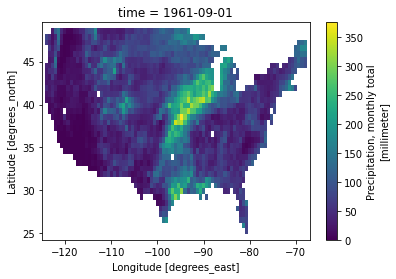

In [15]:
time_step = 800
ds.prcp[:, :, time_step].plot()

In [32]:
stacked_ds = ds.stack(grid_cells=('lat', 'lon',))
stacked_ds

spi_ds = stacked_ds.groupby('grid_cells').apply(
    spi_wrapper,
    precip_var='prcp',
    scale=3,
    distribution=Distribution.gamma,
    data_start_year=1895,
    calibration_year_initial=1895,
    calibration_year_final=2017,
    periodicity=Periodicity.monthly,
).unstack('grid_cells')

In [41]:
stacked_ds

<xarray.Dataset>
Dimensions:     (time: 1466, grid_cells: 3306)
Coordinates:
  * time        (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-02-01
  * grid_cells  (grid_cells) MultiIndex
  - lat         (grid_cells) float64 24.56 24.56 24.56 ... 49.23 49.23 49.23
  - lon         (grid_cells) float64 -124.7 -124.0 -123.4 ... -68.02 -67.35
Data variables:
    prcp        (time, grid_cells) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/17)
    date_created:              2017-01-04 04:00:08.008484
    date_modified:             2017-01-04 04:00:08.011881
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    history:                   Sat Apr 28 02:50:28 2018: C:\home\miniconda\Li...
    NCO:                       4.7.1
    nco_openmp_thread_number:  1

In [33]:
spi_ds

<xarray.DataArray (time: 1466, lat: 38, lon: 87)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan, -0.42616304, -0.7263655 , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan, -1.14066499, -0.627348  , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-02-01
  * lat      (lat) float64 24.56 25.23 25.9 26.56 ... 47.23 47.9 48.56 49.23
  * lon      (lon) float64 -124.7 -124.0 -123.4 -122.7 ... -68.69 -68.02 -67.35
Attributes:
    description:  SPI computed by the climate_indices Python package
    references:   https://github.com/monocongo/climate_indices
    valid_min:    -3.09
    valid_max:    3.09